# The Fundamentals of Autograd

This notebook is referenced from the third video in the [PyTorch Beginner Series](https://www.youtube.com/playlist?list=PL_lsbAsL_o2CTlGHgMxNrKhzP97BaG9ZN) by Brad Heintz on YouTube. The video focuses on the basic concepts in PyTorch that are used to handle several deep learning tasks and demonstrates how these concepts come together to make PyTorch a robust machine learning framework. You can find the notebook associated with the video [here](https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html).


In [1]:
# Import libraries here
from typing import Any, Optional

import torch
from torch import Tensor

from scripts import plot_utils

## What Does the Autograd Do?

The autograd provides the following functionalities:

- It allows easy computation of multiple gradients over a complex computation.
- It traces the computation dynamically at runtime as the computation graph.

The aim of the autograd is to keep track of all the gradients so that redundant computations are avoided during backpropagation.


In [2]:
# Create a tensor with values in [0, 2\pi]
a = torch.linspace(0., 2. * torch.pi, steps=25, requires_grad=True)
print(f'Tensor `a`:\n{a}')

Tensor `a`:
tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)


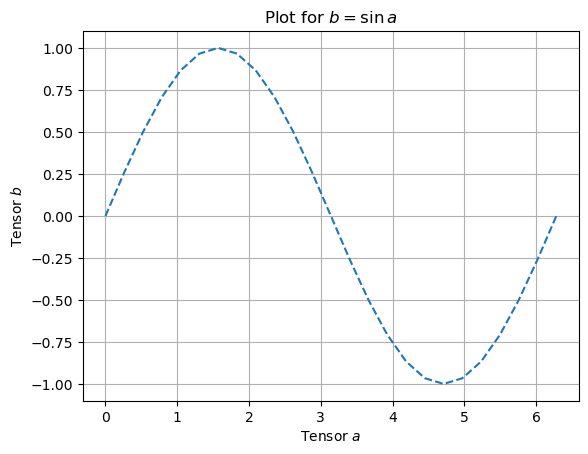

In [3]:
# Perform a computation with `a`
b = torch.sin(a)

# Plot the result
plot_utils.relplot(
    a.detach(), b.detach(),
    xlabel='Tensor $a$',
    ylabel='Tensor $b$',
    title='Plot for $b = \sin a$',
)

In [4]:
# View the new tensor `b`
print(f'Tensor `b`:\n{b}')

Tensor `b`:
tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01, -8.7423e-08, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.7485e-07],
       grad_fn=<SinBackward0>)


Here, the gradient function showcases what operation will be performed during backpropagation.


In [5]:
# Perform more computations
c = 2 * b
print(f'Tensor `c`:\n{c}\n')

d = c + 1
print(f'Tensor `d`:\n{d}')

Tensor `c`:
tensor([ 0.0000e+00,  5.1764e-01,  1.0000e+00,  1.4142e+00,  1.7321e+00,
         1.9319e+00,  2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,
         1.0000e+00,  5.1764e-01, -1.7485e-07, -5.1764e-01, -1.0000e+00,
        -1.4142e+00, -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00,
        -1.7321e+00, -1.4142e+00, -1.0000e+00, -5.1764e-01,  3.4969e-07],
       grad_fn=<MulBackward0>)

Tensor `d`:
tensor([ 1.0000e+00,  1.5176e+00,  2.0000e+00,  2.4142e+00,  2.7321e+00,
         2.9319e+00,  3.0000e+00,  2.9319e+00,  2.7321e+00,  2.4142e+00,
         2.0000e+00,  1.5176e+00,  1.0000e+00,  4.8236e-01, -3.5763e-07,
        -4.1421e-01, -7.3205e-01, -9.3185e-01, -1.0000e+00, -9.3185e-01,
        -7.3205e-01, -4.1421e-01,  4.7684e-07,  4.8236e-01,  1.0000e+00],
       grad_fn=<AddBackward0>)


In [6]:
# Compute an output
out = d.sum()
out

tensor(25., grad_fn=<SumBackward0>)

The major takeaways from these computations are as follows:

- The gradient function of each tensor allows you to walk the computation backwards.
- The backward method requires that the calling tensor is single-valued, as is the case for loss function.


In [7]:
# Walk the whole computation backwards
print('Walking backwards from `out`:')
print(out.grad_fn)
print(out.grad_fn.next_functions)
print(out.grad_fn.next_functions[0][0].next_functions)
print(out.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(out.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)
print(out.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)

Walking backwards from `out`:
((<AddBackward0 object at 0x157053fa0>, 0),)
((<MulBackward0 object at 0x1570536a0>, 0), (None, 0))
((<SinBackward0 object at 0x157052590>, 0), (None, 0))
((<AccumulateGrad object at 0x1570536a0>, 0),)
()


In [8]:
def print_backward_traversal(tensor: Tensor) -> None:
    """
    Prints the backward traversal of a computation graph starting from the given tensor.

    This function walks backwards from the specified tensor's gradient function through
    the computation graph and prints each function in the path until it reaches the
    beginning of the graph.

    Args:
        tensor (Tensor): The tensor from which to start the backward traversal.
    """
    def get_var_name(var: Any) -> Optional[str]:
        """
        Retrieves the variable name of the given variable from the global scope.

        Args:
            var (Any): The variable for which to find the name.

        Returns:
            Optional[str]: The name of the variable if found, otherwise None.
        """
        names = list(filter(
            lambda x: not x.startswith('_'),
            [name for name, val in globals().items() if val is var],
        ))
        return names[0] if names else None
    
    # Write the header line
    tensor_name = get_var_name(tensor)
    print(f'Walking backwards from `{tensor_name}`:')

    # Print the traversal until `tensor.grad_fn` is None
    curr_grad_fn = tensor.grad_fn
    while curr_grad_fn is not None:
        print(curr_grad_fn)
        curr_grad_fn = (
            curr_grad_fn.next_functions[0][0]
            if curr_grad_fn.next_functions
            else None
        )
    print('Root node of computation graph reached!')

In [9]:
# Walk the computation backwards with the function
print_backward_traversal(out)

Walking backwards from `out`:
Root node of computation graph reached!


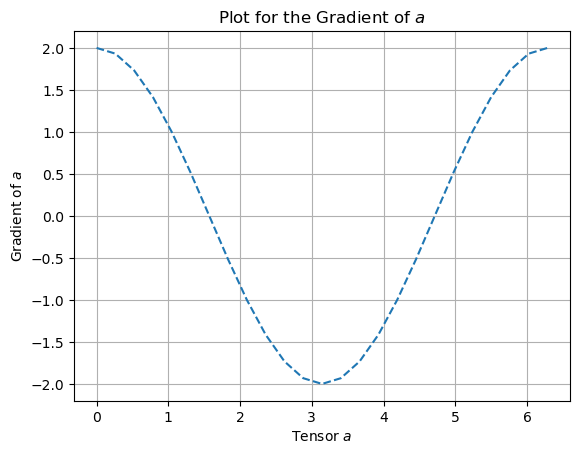

In [10]:
# Calculate the gradients
out.backward()

# Plot the gradient for `a`
plot_utils.relplot(
    a.detach(), a.grad.detach(),
    xlabel='Tensor $a$',
    ylabel='Gradient of $a$',
    title='Plot for the Gradient of $a$',
)

In [11]:
# Get the gradient of `a`
print(f'Tensor `a`:\n{a}\n')
print(f'Gradient of `a`:\n{a.grad}')

Tensor `a`:
tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)

Gradient of `a`:
tensor([ 2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,  1.0000e+00,
         5.1764e-01, -8.7423e-08, -5.1764e-01, -1.0000e+00, -1.4142e+00,
        -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00, -1.7321e+00,
        -1.4142e+00, -1.0000e+00, -5.1764e-01,  2.3850e-08,  5.1764e-01,
         1.0000e+00,  1.4142e+00,  1.7321e+00,  1.9319e+00,  2.0000e+00])


**Note:** The gradients are calculated for only the leaf nodes of the computation graph.


## Using the Autograd in Training

Training a simple model and examining the functioning of the autograd.


In [12]:
# Setup constants
BATCH_SIZE = 16
INPUT_SIZE = 1000
HIDDEN_SIZE = 100
OUTPUT_SIZE = 10

In [13]:
# Define the model architecture
class TinyModel(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super(TinyModel, self).__init__(*args, **kwargs)

        # Define the layers and activations
        self.layer1 = torch.nn.Linear(INPUT_SIZE, HIDDEN_SIZE)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)

    def forward(self, x: Tensor) -> Tensor:
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)

        return x

In [14]:
# Generate random inputs from the normal distribution
some_input = torch.randn(BATCH_SIZE, INPUT_SIZE, requires_grad=False)
print(f'Shape of Input Tensor  : {some_input.shape}')

# Generate ideal outputs as mappings to the inputs
ideal_output = torch.randn(BATCH_SIZE, OUTPUT_SIZE, requires_grad=False)
print(f'Shape of Output Tensor : {ideal_output.shape}')

# Initialize the model
model = TinyModel()
print(f'\n{model}')

Shape of Input Tensor  : torch.Size([16, 1000])
Shape of Output Tensor : torch.Size([16, 10])

TinyModel(
  (layer1): Linear(in_features=1000, out_features=100, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=100, out_features=10, bias=True)
)


In [15]:
# Peek at the layer weights of the model
print(f'Weights at Layer-1:\n{model.layer1.weight[0][:10]}\n')
print(f'Weights at Layer-2:\n{model.layer2.weight[0][:10]}\n')

# Note that the gradients have not been calculated yet
print(f'Gradient for Layer-1:\n{model.layer1.weight.grad}\n')
print(f'Gradient for Layer-2:\n{model.layer2.weight.grad}')

Weights at Layer-1:
tensor([-0.0038, -0.0233,  0.0033, -0.0100,  0.0034, -0.0116,  0.0208, -0.0139,
         0.0307,  0.0017], grad_fn=<SliceBackward0>)

Weights at Layer-2:
tensor([-0.0051,  0.0713, -0.0612, -0.0864,  0.0565, -0.0573, -0.0752,  0.0415,
         0.0782,  0.0916], grad_fn=<SliceBackward0>)

Gradient for Layer-1:
None

Gradient for Layer-2:
None


In [16]:
# Setup an optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Train and run through one training batch
prediction = model(some_input)

# Compute the squared loss
loss = (ideal_output - prediction).pow(2).sum()
loss

tensor(189.6772, grad_fn=<SumBackward0>)

In [17]:
# Compute the gradients through backpropagation
loss.backward()

# Print the updated weights
print(f'Weights at Layer-1:\n{model.layer1.weight[0][:10]}\n')
print(f'Weights at Layer-2:\n{model.layer2.weight[0][:10]}\n')

# Print the updated gradients
print(f'Gradient for Layer-1:\n{model.layer1.weight.grad[0][:10]}\n')
print(f'Gradient for Layer-2:\n{model.layer2.weight.grad[0][:10]}')

Weights at Layer-1:
tensor([-0.0038, -0.0233,  0.0033, -0.0100,  0.0034, -0.0116,  0.0208, -0.0139,
         0.0307,  0.0017], grad_fn=<SliceBackward0>)

Weights at Layer-2:
tensor([-0.0051,  0.0713, -0.0612, -0.0864,  0.0565, -0.0573, -0.0752,  0.0415,
         0.0782,  0.0916], grad_fn=<SliceBackward0>)

Gradient for Layer-1:
tensor([-2.0286,  0.6462,  1.1236, -1.3590,  1.2687, -1.0156,  0.2944,  0.4527,
         0.4669,  0.2544])

Gradient for Layer-2:
tensor([ 1.9493,  1.1163, -0.7354,  0.7908,  0.3887, -1.2073, -0.7758, -1.4334,
        -1.6153, -1.1699])


The gradients have been calculated but the weights weren't updated.


In [18]:
# Run the optimizer to update the weights
optimizer.step()

# Print the updated weights
print(f'Weights at Layer-1:\n{model.layer1.weight[0][:10]}\n')
print(f'Weights at Layer-2:\n{model.layer2.weight[0][:10]}\n')

# Print the updated gradients
print(f'Gradient for Layer-1:\n{model.layer1.weight.grad[0][:10]}\n')
print(f'Gradient for Layer-2:\n{model.layer2.weight.grad[0][:10]}')

Weights at Layer-1:
tensor([-0.0018, -0.0240,  0.0022, -0.0086,  0.0021, -0.0105,  0.0205, -0.0144,
         0.0302,  0.0014], grad_fn=<SliceBackward0>)

Weights at Layer-2:
tensor([-0.0071,  0.0702, -0.0604, -0.0872,  0.0561, -0.0561, -0.0744,  0.0429,
         0.0798,  0.0927], grad_fn=<SliceBackward0>)

Gradient for Layer-1:
tensor([-2.0286,  0.6462,  1.1236, -1.3590,  1.2687, -1.0156,  0.2944,  0.4527,
         0.4669,  0.2544])

Gradient for Layer-2:
tensor([ 1.9493,  1.1163, -0.7354,  0.7908,  0.3887, -1.2073, -0.7758, -1.4334,
        -1.6153, -1.1699])


In [19]:
# You need to clear the optimizer after calling the step function
# so that applying backpropagation does not accumulate the gradients
# onto the learned weights.

print(f'Gradient for Layer-2 (after the 1st epoch):')
print(model.layer2.weight.grad[0][:10])

# Train for another 5 epochs
for i in range(5):
    prediction = model(some_input)
    loss = (ideal_output - prediction).pow(2).sum()
    loss.backward()

print(f'\nGradient for Layer-2 (after the 6th epoch):')
print(model.layer2.weight.grad[0][:10])

# Clear the optimizer
optimizer.zero_grad(set_to_none=False)

print(f'\nGradient for Layer-2 (after clearing the optimizer):')
print(model.layer2.weight.grad[0][:10])

Gradient for Layer-2 (after the 1st epoch):
tensor([ 1.9493,  1.1163, -0.7354,  0.7908,  0.3887, -1.2073, -0.7758, -1.4334,
        -1.6153, -1.1699])

Gradient for Layer-2 (after the 6th epoch):
tensor([21.2269, -4.1524, -1.8403,  3.0453,  5.9593, -8.2203,  2.9902, -3.8459,
        -8.8290, -0.2695])

Gradient for Layer-2 (after clearing the optimizer):
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


The magnitude of gradients blow up after running through multiple backward passes (compare 1st vs 6th epochs).


## Turning Autograd On and Off

The various ways to turn off the autograd are as follows:

- Set the `requires_grad` parameter to False.
- Use the `torch.no_grad()` context manager.

The various ways to turn on the autograd are as follows:

- Set the `requires_grad` parameter to True.
- Use the `torch.enable_grad()` context manager.


In [20]:
a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c_with_autograd = a + b
print(f'Tensor with autograd enabled:\n{c_with_autograd}\n')

# Use the context manager to turn off the autograd
with torch.no_grad():
    c_without_autograd = a + b

print(f'Tensor with autograd disabled:\n{c_without_autograd}\n')

# Use the context manager as a decorator
@torch.no_grad()
def add_tensors_disabled(x: Tensor, y: Tensor) -> Tensor:
    return x + y

c_without_autograd_dec = add_tensors_disabled(a, b)
print(f'Tensor with autograd disabled (decorated):\n{c_without_autograd_dec}\n')

c_with_autograd_again = a + b
print(f'Tensor with autograd enabled (again):\n{c_with_autograd_again}')

Tensor with autograd enabled:
tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)

Tensor with autograd disabled:
tensor([[5., 5., 5.],
        [5., 5., 5.]])

Tensor with autograd disabled (decorated):
tensor([[5., 5., 5.],
        [5., 5., 5.]])

Tensor with autograd enabled (again):
tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)


In [21]:
# Use the `torch.enable_grad()` context manager (inside the function)
@torch.enable_grad()
def add_tensors_enabled(x: Tensor, y: Tensor) -> Tensor:
    return x + y

p = torch.ones(2, 3, requires_grad=False) * 2
q = torch.ones(2, 3, requires_grad=False) * 3

r_disabled = p + q

# Enable `requires_grad`
p.requires_grad_()
q.requires_grad_()

r_enabled = add_tensors_enabled(p, q)

print(f'Tensor with autograd disabled:\n{r_disabled}\n')
print(f'Tensor with autograd enabled:\n{r_enabled}')

Tensor with autograd disabled:
tensor([[5., 5., 5.],
        [5., 5., 5.]])

Tensor with autograd enabled:
tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)


In [22]:
# Use the `detach()` method to return a
# autograd-disabled copy of the tensor

x = torch.rand(5, requires_grad=True)
y = x.detach()

print(f'Tensor `x`:\n{x}\n')
print(f'Tensor `y`:\n{y}')

Tensor `x`:
tensor([0.0311, 0.6831, 0.5673, 0.1521, 0.9167], requires_grad=True)

Tensor `y`:
tensor([0.0311, 0.6831, 0.5673, 0.1521, 0.9167])


## Using the Autograd Profiler

Since autograd keeps track of every step of the computation in detail, it can be used as a handy profiler.


In [23]:
# Select the device and search for the GPU
device = torch.device('cpu')
run_on_gpu = False
if torch.cuda.is_available():
    device = torch.device('cuda')
    run_on_gpu = True

# Create some tensors with autograd-enabled
x = torch.randn(2, 3, requires_grad=True)
y = torch.rand(2, 3, requires_grad=True)
z = torch.ones(2, 3, requires_grad=True)

# Use the autograd profiler
with torch.autograd.profiler.profile(use_cuda=run_on_gpu) as prf:
    # Perform 1000 computations
    for _ in range(1000):
        z = (z / x) * y

# Display the profiler key log
print(prf.key_averages().table(sort_by='self_cpu_time_total'))

-------------  ------------  ------------  ------------  ------------  ------------  ------------  
         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------  ------------  ------------  ------------  ------------  ------------  ------------  
    aten::div        53.81%       1.827ms        53.81%       1.827ms       1.827us          1000  
    aten::mul        46.19%       1.568ms        46.19%       1.568ms       1.568us          1000  
-------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 3.395ms



STAGE:2024-07-06 13:11:36 77536:3916008 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-07-06 13:11:36 77536:3916008 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-07-06 13:11:36 77536:3916008 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


## Using the High-Level API

The autograd provides a high-level API to access various functions to compute differential matrix and vector operations.


In [24]:
# Setup a function
def exp_adder(x: Tensor, y: Tensor):
    return 2 * x.exp() + 3 * y

inputs = (torch.rand(1), torch.rand(1))
print(f'Inputs:\n{inputs}\n')

# Get the Jacobian for the inputs
derivative_1deg = torch.autograd.functional.jacobian(exp_adder, inputs)
print(f'Jacobian:\n{derivative_1deg}\n')

# Get the Hessian for the inputs
derivative_2deg = torch.autograd.functional.hessian(exp_adder, inputs)
print(f'Hessian:\n{derivative_2deg}')

Inputs:
(tensor([0.7553]), tensor([0.7522]))

Jacobian:
(tensor([[4.2564]]), tensor([[3.]]))

Hessian:
((tensor([[4.2564]]), tensor([[0.]])), (tensor([[0.]]), tensor([[0.]])))
